In [23]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pickle
import os
import torch.utils.data as data
from PIL import Image
import lmdb
import numpy as np
import pickle
import torch
import torchvision.transforms as transforms
import json
import sys
from tqdm import tqdm

In [25]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive/MyDrive/MML')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def default_loader(path):
    try:
        im = Image.open(path).convert('RGB')
        return im
    except:
        # print(..., file=sys.stderr)
        return Image.new('RGB', (224, 224), 'white')
       
class ImageLoader(data.Dataset):
    def __init__(self, img_path, transform=None, target_transform=None,
                 loader=default_loader, square=False, data_path=None, partition=None, sem_reg=None):

        if data_path == None:
            raise Exception('No data path specified.')

        if partition is None:
            raise Exception('Unknown partition type %s.' % partition)
        else:
            self.partition = partition

        self.env = lmdb.open(os.path.join(data_path, partition + '_lmdb'), max_readers=1, readonly=True, lock=False,
                             readahead=False, meminit=False)

        with open(os.path.join(data_path, partition + '_keys.pkl'), 'rb') as f:
            self.ids = pickle.load(f)

        self.square = square
        self.imgPath = img_path
        self.mismtch = 0.8
        self.maxInst = 20

        if sem_reg is not None:
            self.semantic_reg = sem_reg
        else:
            self.semantic_reg = False

        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

        with open('drive/MyDrive/MML/data/cleaned_ingredients.json', 'r') as f:
            self.ingredients = json.load(f)
        
        with open('drive/MyDrive/MML/data/cleaned_layers.json', 'r') as f:
            self.recipes = json.load(f)

    def __getitem__(self, index):
        recipId = self.ids[index]
        # print(f"RECIPE ID: {recipId}")
        # we force 80 percent of them to be a mismatch
        if self.partition == 'train':
            match = np.random.uniform() > self.mismtch
        elif self.partition == 'val' or self.partition == 'test':
            match = True
        else:
            raise 'Partition name not well defined'

        target = match and 1 or -1

        with self.env.begin(write=False) as txn:
            serialized_sample = txn.get(self.ids[index].encode('latin1'))
        sample = pickle.loads(serialized_sample,encoding='latin1')
        imgs = sample['imgs']

        # image
        if target == 1:
            if self.partition == 'train':
                # We do only use the first five images per recipe during training
                imgIdx = np.random.choice(range(min(5, len(imgs))))
            else:
                imgIdx = 0

            loader_path = [imgs[imgIdx]['id'][i] for i in range(4)]
            loader_path = os.path.join(*loader_path)
            # path = os.path.join(self.imgPath, self.partition, loader_path, imgs[imgIdx]['id'])
            path = os.path.join(self.imgPath, loader_path, imgs[imgIdx]['id'])
        else:
            # we randomly pick one non-matching image
            all_idx = range(len(self.ids))
            rndindex = np.random.choice(all_idx)
            while rndindex == index:
                rndindex = np.random.choice(all_idx)  # pick a random index

            with self.env.begin(write=False) as txn:
                serialized_sample = txn.get(self.ids[rndindex].encode('latin1'))

            rndsample = pickle.loads(serialized_sample,encoding='latin1')
            rndimgs = rndsample['imgs']

            if self.partition == 'train':  # if training we pick a random image
                # We do only use the first five images per recipe during training
                imgIdx = np.random.choice(range(min(5, len(rndimgs))))
            else:
                imgIdx = 0

            loader_path = [rndimgs[imgIdx]['id'][i] for i in range(4)]
            loader_path = os.path.join(*loader_path)
            path = os.path.join(self.imgPath, loader_path, rndimgs[imgIdx]['id'])
            # path = self.imgPath + rndimgs[imgIdx]['id']

        # instructions
        instrs = sample['intrs']
        itr_ln = len(instrs)
        t_inst = np.zeros((self.maxInst, np.shape(instrs)[1]), dtype=np.float32)
        t_inst[:itr_ln][:] = instrs
        instrs = torch.FloatTensor(t_inst)

        # ingredients
        ingrs = sample['ingrs'].astype(int)
        ingrs = torch.LongTensor(ingrs)
        igr_ln = max(np.nonzero(sample['ingrs'])[0]) + 1

        # load image
        img = self.loader(path)

        if self.square:
            img = img.resize(self.square)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        rec_class = sample['classes'] - 1
        rec_id = self.ids[index]

        if target == -1:
            img_class = rndsample['classes'] - 1
            img_id = self.ids[rndindex]
        else:
            img_class = sample['classes'] - 1
            img_id = self.ids[index]

        # read from JSON files and load text ingredients + instructions
        ingredients = self.ingredients[recipId]
        title = self.recipes[recipId]['title']
        instructions = self.recipes[recipId]['instructions']

        # output
        if self.partition == 'train':
            if self.semantic_reg:
                return [img, instrs, itr_ln, ingrs, igr_ln, title, ingredients, instructions], [target, img_class, rec_class]
            else:
                return [img, instrs, itr_ln, ingrs, igr_ln, title, ingredients, instructions], [target]
        else:
            if self.semantic_reg:
                return [img, instrs, itr_ln, ingrs, igr_ln, title, ingredients, instructions], [target, img_class, rec_class, img_id, rec_id]
            else:
                return [img, instrs, itr_ln, ingrs, igr_ln, title, ingredients, instructions], [target, img_id, rec_id]

    def __len__(self):
        return len(self.ids)

In [27]:
img_path = 'drive/MyDrive/MML/data/images/'
data_path = 'drive/MyDrive/MML/data/'
semantic_reg = True
batch_size = 160
num_workers = 30

In [28]:
# input index 0 is image embedding
# input index 1-4 embeddings for words and recipe
# think 1 is instructions, 2 is instructions length
# think 3 is ingredients, 4 is ingredients length

In [29]:
def print_batch(input, target):
    print("INPUT:", len(input), "TARGET:", len(target))
    print(f"IMAGE: {input[0].shape}\n\nINSTRUCTIONS: {input[1].shape}\n\nINSTRUCTIONS LENGTH: {input[2]}\n\nINGREDIENTS: {input[3]}\n\nINGREDIENTS LENGTH: {input[4]}\n\nTITLE: {input[5]}\n\nINGREDIENTS: {input[6]}\n\nINSTRUCTIONS: {input[7]}\n\n")
    print(f"TARGET: {target[0]}\n\nIMAGE ID: {target[1]}\n\nRECIPE ID: {target[2]}\n\n")
    print(f"INSTRUCTIONS PRINTING1: {input[1][0][0].shape}, {input[1][0][0]}")
    # print(f"INSTRUCTIONS PRINTING2: {input[1][0][1].shape}, {input[1][0][1]}")
    # print(f"INSTRUCTIONS PRINTING8: {input[1][0][8].shape}, {input[1][0][8]}")
    # print(f"INSTRUCTIONS PRINTING9: {input[1][0][9].shape}, {input[1][0][9]}")
    print("\n\n-----------------------------------------------------------------------------------------------------------------------------------\n\n")

data_loader = data.DataLoader(
    ImageLoader(
        '../test/',
        transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        data_path='drive/MyDrive/MML/data',
        partition='test'),
    batch_size=1,
    shuffle=False
)

for i, (input, target) in enumerate(data_loader):
    print_batch(input, target)

    if i == 0:
        break

INPUT: 8 TARGET: 3
IMAGE: torch.Size([1, 3, 224, 224])

INSTRUCTIONS: torch.Size([1, 20, 1024])

INSTRUCTIONS LENGTH: tensor([9])

INGREDIENTS: tensor([[   35,    40,   105,  3148, 11830,  2265,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

INGREDIENTS LENGTH: tensor([7])

TITLE: ('Crunchy Onion Potato Bake',)

INGREDIENTS: [('milk',), ('water',), ('butter',), ('mashed potatoes',), ('whole kernel corn',), ('cheddar cheese',), ('French - fried onions',)]

INSTRUCTIONS: [('Preheat oven to 350 degrees Fahrenheit.',), ('Spray pan with non stick cooking spray.',), ('Heat milk, water and butter to boiling; stir in contents of both pouches of potatoes; let stand one minute.',), ('Stir in corn.',), ('Spoon half the potato mixture in pan.',), ('Sprinkle half each of cheese and onions; top with remaining potatoes.',), ('Sprinkle with remaining cheese and onions.',), ('Bake 10 to 15 minutes until cheese is melted.',), ('Enjoy !',)]



In [30]:
label_index = 0
title_indices = []
titles = []
ingredients = []
instructions = []
title_map = dict()

for i, (input, target) in enumerate(tqdm(data_loader)):
    if i == 0:
      ingr_encoding = input[3].numpy()
      rec_encoding = input[1][0].numpy().flatten()
      rec_encoding = np.expand_dims(rec_encoding, axis=0)
    else:
      ingr_encoding = np.concatenate((ingr_encoding, input[3].numpy()))
      flat_rec_encoding = input[1][0].numpy().flatten()
      flat_rec_encoding = np.expand_dims(flat_rec_encoding, axis=0)
      rec_encoding = np.concatenate((rec_encoding, flat_rec_encoding))
    
    if title_map.get(input[5][0]) == None:
      title_map[input[5][0]] = label_index
      title_indices.append(title_map.get(input[5][0]))
      titles.append(input[5][0])
      label_index += 1
    else:
      title_indices.append(title_map.get(input[5][0]))
      titles.append(input[5][0])

    ingredients.append(input[6])
    instructions.append(input[7])
    
    if i == 9999:
    # if i == 2:
        break

 19%|█▉        | 9999/51334 [23:20<1:36:31,  7.14it/s]


In [31]:
ingr_encoding.shape, rec_encoding.shape, len(titles)

((10000, 20), (10000, 20480), 10000)

In [32]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(rec_encoding)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(10000, 2)

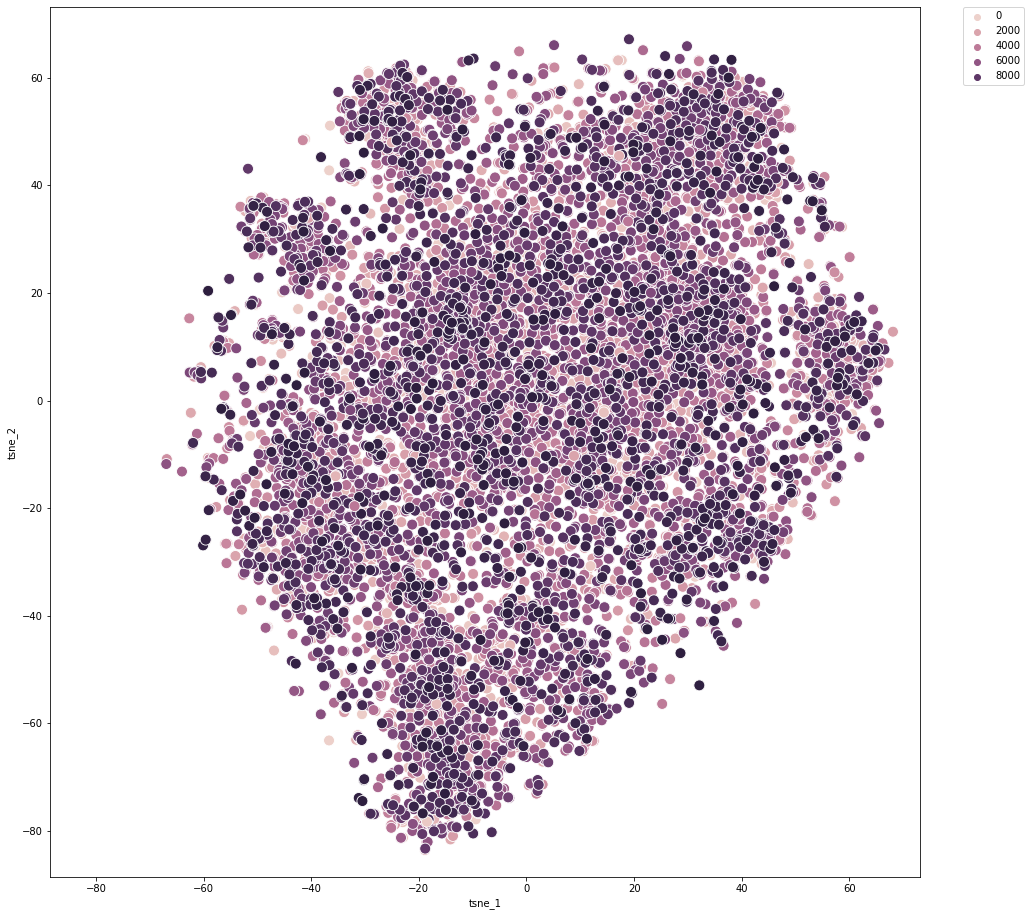

In [33]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': title_indices, 'food_title': titles})
fig, ax = plt.subplots(1, figsize=(16,16))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [34]:
tsne_result_df.head()

,tsne_1,tsne_2,label,food_title
0,-50.241802,-27.079779,0,Crunchy Onion Potato Bake
1,-42.763794,-25.032892,1,Butternut Squash Soup or Bisque (Roasting Method)
2,-26.599232,-30.843748,2,Gyro Meat Loaf W/ Tzatziki Sauce
3,19.923626,47.598366,3,Calico Beans
4,-12.135418,-64.060249,4,Harriet's Bran Muffins


In [35]:
# x and y given as array_like objects
import plotly.express as px
fig = px.scatter(tsne_result_df, x="tsne_1", y="tsne_2", color="label", hover_data=['tsne_1', 'tsne_2', 'label', 'food_title'])
fig.show()

In [36]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [41]:
# titles
# ingredients
# instructions
titles[0], ingredients[0], instructions[0]

('Crunchy Onion Potato Bake',
 ['milk',
  'water',
  'butter',
  'mashed potatoes',
  'whole kernel corn',
  'cheddar cheese',
  'French - fried onions'],
 ['Preheat oven to 350 degrees Fahrenheit.',
  'Spray pan with non stick cooking spray.',
  'Heat milk, water and butter to boiling; stir in contents of both pouches of potatoes; let stand one minute.',
  'Stir in corn.',
  'Spoon half the potato mixture in pan.',
  'Sprinkle half each of cheese and onions; top with remaining potatoes.',
  'Sprinkle with remaining cheese and onions.',
  'Bake 10 to 15 minutes until cheese is melted.',
  'Enjoy !'])

In [66]:
# Encode the sentence
encoded = tokenizer.encode_plus(
    text=[titles[0], titles[1]],  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 20,  # maximum length of a sentence
    padding='max_length',  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
)

In [88]:
# Encode the sentence
tokenized_titles = tokenizer(
    text=titles,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 30,  # maximum length of a sentence
    padding='max_length',  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
)['input_ids']

In [89]:
len(tokenized_titles[0]), len(tokenized_titles[1]), len(tokenized_titles[2])

(30, 30, 30)

In [90]:
np_tokenized_titles = np.array(tokenized_titles)

In [95]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result_BERT = tsne.fit_transform(np_tokenized_titles)
tsne_result_BERT.shape
# (1000, 2)
# Two dimensions for each of our images

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(10000, 2)

In [96]:
# x and y given as array_like objects
import plotly.express as px
tsne_result_BERT_df = pd.DataFrame({'tsne_1': tsne_result_BERT[:,0], 'tsne_2': tsne_result_BERT[:,1], 'label': title_indices, 'food_title': titles})
fig = px.scatter(tsne_result_BERT_df, x="tsne_1", y="tsne_2", color="label", hover_data=['tsne_1', 'tsne_2', 'label', 'food_title'])
fig.show()